# Manual Gibbs sampling in Edward

This notebook examines the Tensorflow graphs built by a simple Edward model.

## Boilerplate

In [2]:
import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import Normal
sess = ed.get_session()

In [3]:
# Adapted from https://stackoverflow.com/questions/38189119
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## Model: a chain of Normals

First we'll declare three random variables, instances of `ed.RandomVariable`.

In [4]:
x = Normal(0.0, 1.0)
y = Normal(x, 1.0)
z = Normal(y, 1.0)

This has already created a tensorflow graph under the hood. Tensorboard's visualization is nested, so you can click on the nodes (actually **scopes** or groups) to expand.

In [4]:
show_graph(tf.get_default_graph())

## Inference: Gibbs sampling

To perform inference, we'll start by observing `z` and randomly initializing `x` and `y`.

In [5]:
z_obs = 0.5  # Observe
x_est, y_est = sess.run([x, y])  # Initialiize randomly
x_est, y_est

(-1.6195725, -1.5457522)

To do Gibbs sampling, we'll use Edward to compute complete conditional distributions. This analyzes the tensorflow graph

In [6]:
x_cond = ed.complete_conditional(x)
y_cond = ed.complete_conditional(y)

These statements have added new nodes to the tensorflow graph.

In [8]:
show_graph(tf.get_default_graph())

Edward precomputes extra pieces of the graph (e.g. gradients) that we won't be using in Gibbs sampling. To simplify our view, let's strip all the unused portions of the graph. We'll use the same stripping logic that is used internally during graph execution.

In [51]:
from tensorflow.python.tools.strip_unused_lib import strip_unused
help(strip_unused)

Help on function strip_unused in module tensorflow.python.tools.strip_unused_lib:

strip_unused(input_graph_def, input_node_names, output_node_names, placeholder_type_enum)
    Removes unused nodes from a GraphDef.
    
    Args:
      input_graph_def: A graph with nodes we want to prune.
      input_node_names: A list of the nodes we use as inputs.
      output_node_names: A list of the output nodes.
      placeholder_type_enum: The AttrValue enum for the placeholder data type, or
          a list that specifies one value per input node name.
    
    Returns:
      A GraphDef with all unnecessary ops removed.



In [52]:
g = strip_unused(
    input_graph_def=tf.get_default_graph().as_graph_def(),
    input_node_names=['Normal/loc/input', 'Normal/scale/input'],
    output_node_names=['complete_conditional_Normal_2/cond_dist_1/sample/Reshape'],
    placeholder_type_enum=0)

In [53]:
show_graph(g)

## Execution

Let's generate a chain of 1000 samples.

In [7]:
T = 1000
xy = np.zeros([2, T])
for t in range(T):
    x_est = sess.run(x_cond, {y: y_est})
    y_est = sess.run(y_cond, {x: x_est, z: z_obs})
    xy[0][t] = x_est
    xy[1][t] = y_est

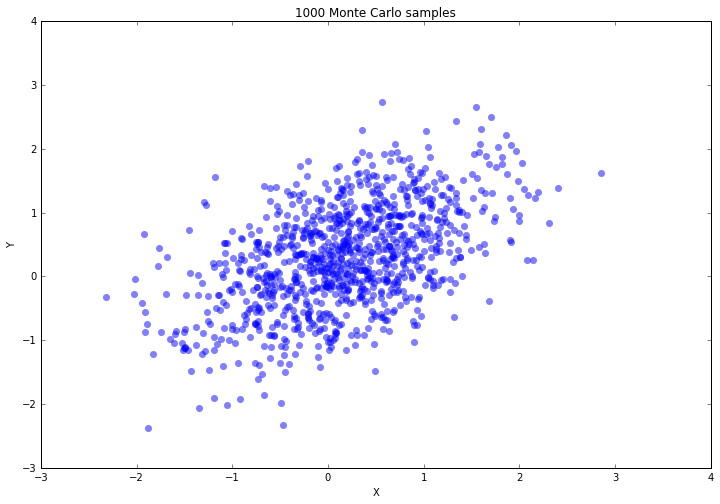

In [16]:
%matplotlib inline
from matplotlib import pyplot
pyplot.figure(figsize=(12, 8))
pyplot.scatter(xy[0], xy[1], 50, lw=0, alpha=0.5)
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.title('{} Monte Carlo samples'.format(T));

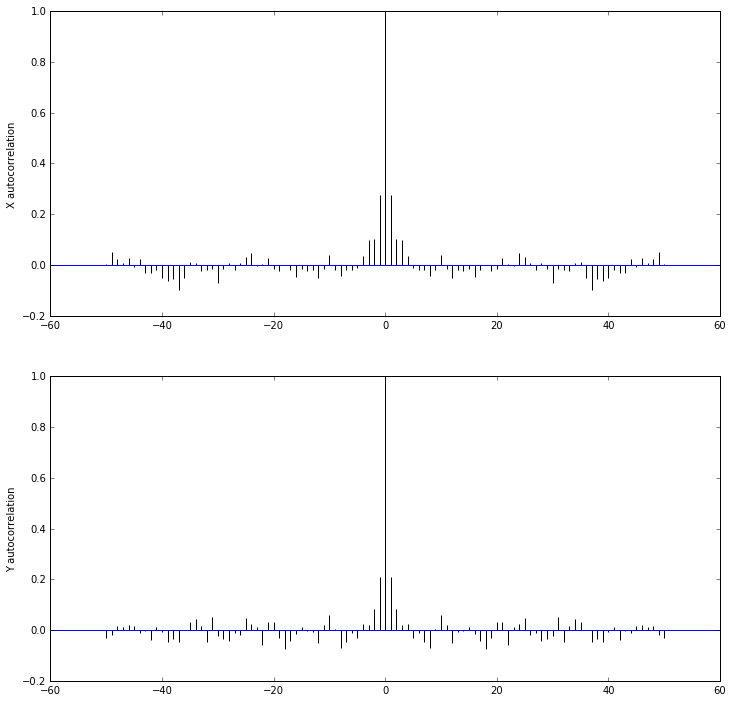

In [17]:
%matplotlib inline
fig, axes = pyplot.subplots(nrows=2, figsize=(12, 12))
axes[0].acorr(xy[0] - xy[0].mean(), maxlags=50)
axes[1].acorr(xy[1] - xy[1].mean(), maxlags=50)
axes[0].set_ylabel('X autocorrelation')
axes[1].set_ylabel('Y autocorrelation');